#     Machine Learning in Finance
##     NOVA IMS
####     Group G: Carlos Cardoso - 20211220 | Carlota Reis - 20211208 | Guilherme Miranda - 20210420 | Mariana Garcia - 20210838 

# Project 3 - Clustering
## Insurance company customers' segmentation 
### This notebook uses the *a2z_insurance.sas7bdat* dataset

(c) Vasco Jesus, Nuno António 2020-2022 - Rev. 1.0

## Dataset description

- **CustID**: numeric - customer ID
- **FirstPolYear**: numeric - year of the customer's first policy. Maybe considered the first year as a customer
- **BirthYear**: numeric - birth year of the customer. The current year of the database is 2016
- **EducDeg**: categorical - academic degree
- **MonthSal**: numerical - monthly gross salary (€)
- **GeoLivArea**: numerical - codes about the area of living. No additional information is available for these codes
- **Children**: numerical - indication if the customer has children (0: no, 1: yes)
- **CustMonVal**: numerical - customer monetary value (CMV). CMV = (annual profit from the customer) x (number of years since a customer) - (acquisition cost)
- **ClaimsRate**: numerical - claims rate. Amount paid by the insurance company (€)/Premiums(€) (in the last two years)
- **PremMotor**: numerical - premiums in the Line of Business (LOB) Motor (€)
- **PremHousehold**: numerical - premiums in the LOB Household (€)
- **PremHealth**: numerical - premiums in the LOB Health (€)
- **PremLife**: numerical - premiums in the LOB Life (€)
- **PremWork**: numerical - premiums in the LOB Work (€)

<br>NOTES about all Premiums:
- Annual premiums (2016)
- Negative premiums may manifest reversals occurred in the current year, paid in previous one(s)

## Work description

### Overview
<p>You should organize into groups of 3 to 5 students, where you will assume the role of a consultant. You are asked to develop a Customer Segmentation in such a way that it will be possible for the Marketing Department of an insurance company to understand all the different Customers’ Profiles better.</p>
<p>Employing the CRISP-DM process model, you are expected to define, describe and explain the clusters you chose. Invest time in reasoning how you want to do your clustering, possible approaches, and advantages or disadvantages of different decisions. Simultaneous, you should express the marketing approach you recommend for each cluster.</p>

### Questions or additional informations
For any additional questions, don't hesitate to get in touch with the instructor. The instructor will also act as the insurance company business/project stakeholder.

# ----------------

This project aims to develop a customer segmentation of an insurance company’s clients, in order for the marketing department to understand better its customers and hence apply the most suitable strategies. The considered models will be done through cluster analysis to determine similarities and differences between different clients’ profiles.

## Initializations and data loading

In [1]:
# Loading packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from scipy.cluster.vq import whiten
import riskfolio as rp
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

C:\Users\lotar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\lotar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Loading the dataset and visualizing summary statistics
ds = pd.read_sas('a2z_insurance.sas7bdat', format='sas7bdat')
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42


By checking some initial metrics of the raw data, it is possible to notice the presence of missing values, since the frequency of each variable is not consistent and varies. The maximum “count” is 10 296, which goes in line with the Customer ID. Thus, it is supposed to have data of 10 296 clients of the insurance company. 

The only unique value presented is in the Education Degree feature, which doesn’t go in line with the other customers’ classifications. The most frequent degree is Bachelor or Masters, having a frequency of 4 799, which is equivalent to 46,70% of the customers presenting this educational level.

Concerning the year of the first policy in the insurance company, it ranges from 1974 and 53784, which is most certainly due to a typo when someone registered this client. The average first policy year is 1991 with a median of 1986.

Regarding the clients’ age, there’s also a typo when registering a client, since the minimum birth year is 1028 and it is impossible for someone having 988 years (considering the year 2016). In terms of frequency, the average client has 48 years old (1968) and the youngest customer has 15 years (2001), which most certainly is not related to a car insurance policy. 

By checking the monthly salary, the clients’ average is 2 507€, with a significant standard deviation of 1 157€. The lower bound is 333€, with the highest salary totalling 55 125€. The median presents a value near the average, being 2 502€.

The most frequent area of living is code number 3 and the number of dependents is usually 1 child.

By looking at costs, customers provide, on average, a value of 177,89 (Customer Monetary Value), with the costly customer being way superior to the most profitable one (-165 680 vs. 11 876). In the past 2 years of the data, the amount paid by the insurance is below the premiums received, averaging a Claim Rate of 0.74.

Finally, considering the different types of insurance policies, the insurance company receives, on average, more funds from the Motor Line of Business, followed by the Household line. However, the highest premiums received are also related to the Household but also from the Health Business Line.

In [3]:
# Show top rows
ds.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


## Data Understanding

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10279 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


The data contains 14 columns with information on education, birth year, salary, family and information about the amount paid by types of insurance products

In [5]:
# Check counts of categorical variables
cols = ['EducDeg']
ds[cols].apply(pd.Series.value_counts)

,EducDeg
b'3 - BSc/MSc',4799
b'2 - High School',3510
b'1 - Basic',1272
b'4 - PhD',698


The only categorical variable of the dataset is the Education Degree which is divided into 4 categories: BSc/MSc (bachelor or masters), High School, Basic and PhD. Most of the insurance clients have a master or a bachelor degree, while PhD students are less frequent.

In [6]:
# Check missing values
print(ds.isnull().sum())

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64


Almost all features present missing values except “CustMonVal”, “ClaimsRate” and “PremHousehold”.

In [7]:
# Exploration of categorical variables (checking unknown categories)

#Cross Table of Education Degree and Monthly Salary
table1 = pd.crosstab(index=ds['EducDeg'], columns=ds['MonthSal']).T
table1

#Cross Table of Education Degree and GeoLivArea
table2 = pd.crosstab(index=ds['EducDeg'], columns=ds['GeoLivArea']).T
table2

#Cross Table of GeoLivArea and Monthly Salary
table3 = pd.crosstab(index=ds['GeoLivArea'], columns=ds['MonthSal'])
table3

MonthSal,333.0,334.0,335.0,336.0,340.0,341.0,342.0,344.0,346.0,348.0,...,4857.0,4869.0,4872.0,4883.0,4897.0,4904.0,4995.0,5021.0,34490.0,55215.0
GeoLivArea,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,1,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2.0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3.0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4.0,1,0,1,0,0,2,1,1,0,0,...,1,1,1,2,1,0,0,0,1,1


<AxesSubplot:xlabel='GeoLivArea'>

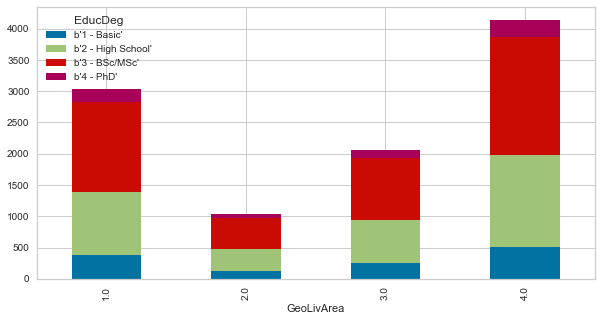

In [8]:
# Visualization

#Education Degree and GeoLivArea
table2.plot(kind="bar", figsize=(10,5), stacked=True)


array([[<AxesSubplot:title={'center':'CustID'}>,
        <AxesSubplot:title={'center':'FirstPolYear'}>,
        <AxesSubplot:title={'center':'BirthYear'}>,
        <AxesSubplot:title={'center':'MonthSal'}>],
       [<AxesSubplot:title={'center':'GeoLivArea'}>,
        <AxesSubplot:title={'center':'Children'}>,
        <AxesSubplot:title={'center':'CustMonVal'}>,
        <AxesSubplot:title={'center':'ClaimsRate'}>],
       [<AxesSubplot:title={'center':'PremMotor'}>,
        <AxesSubplot:title={'center':'PremHousehold'}>,
        <AxesSubplot:title={'center':'PremHealth'}>,
        <AxesSubplot:title={'center':'PremLife'}>],
       [<AxesSubplot:title={'center':'PremWork'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

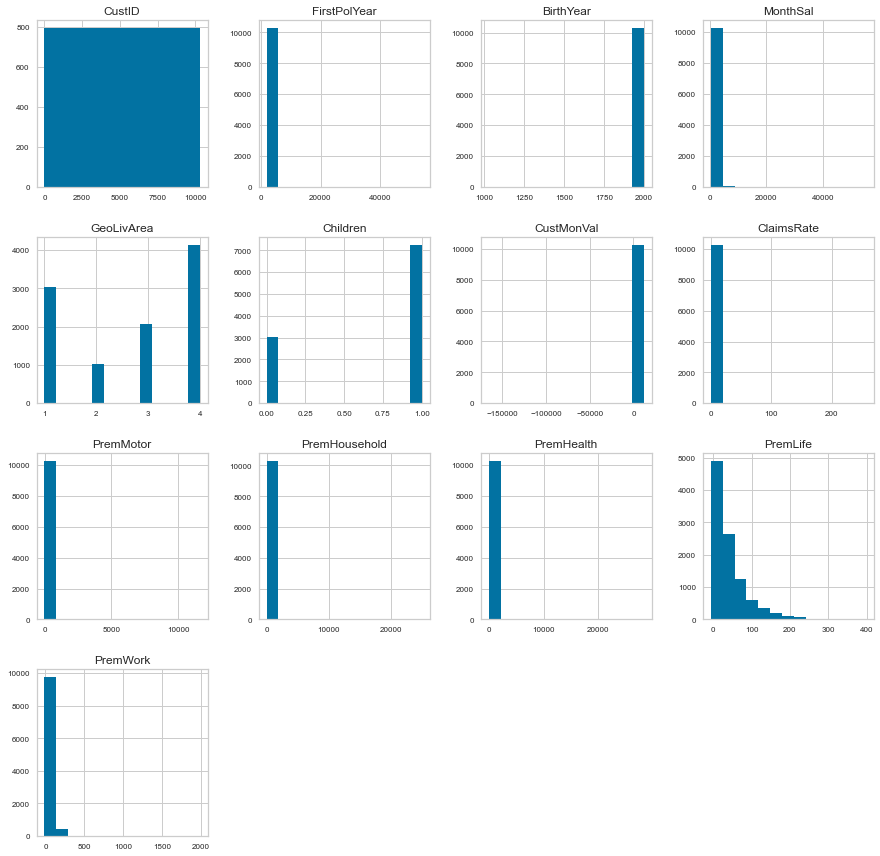

In [9]:
# HISTOGRAM (ALL NUMERIC VARIABLES)

# Identify all numeric variables in the dataset

numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

ds[numerical].hist(bins=13, figsize=(15, 15), layout=(4, 4), xlabelsize=8, ylabelsize=8)


Plotting the considered variables in a histogram, the previously obtained statistics for this dataset can be verified. 

Starting with the variable “FirstPolYear”, almost the entirety of the observations is comprehended between 1974 and 1992. 

Moving forward to the “BirthYear”, the histogram shows that the range of values for this variable is quite limited as well, being all below 2001. 

As for the “MonthSal” variable, the observations for this variable are all concentrated on the lower part of the horizontal axis, being almost all below 3.300 except for some outliers. 

The “GeoLivArea” histogram is composed by four different bars, each representing one of the four categories that compose this variable. Through this, one is able to conclude that the majority of the observations have as attribute the category 4 of this variable and the category 2 is the one that is observed in a smaller number of observations in the dataset. 

“Children” is a binary variable that assumes the values 0 or 1. The histogram shows that most observations of this dataset have, at least, 1 child. 

When analysing the variables “CustMonVal” through the histogram, it is clear that the majority of observations are concentrated in a range of values not far from each other. This same conclusion also applies for the variables “ClaimsRate”, “PremMot”, “PremHousehold”, “PremHealth” and “PremWork”, despite this last variable containing a smaller number of observations with higher values, closer to 500.

 Finally, to what concerns variable “PremLife”, the histogram clearly presents a distribution that is skewed to the right.

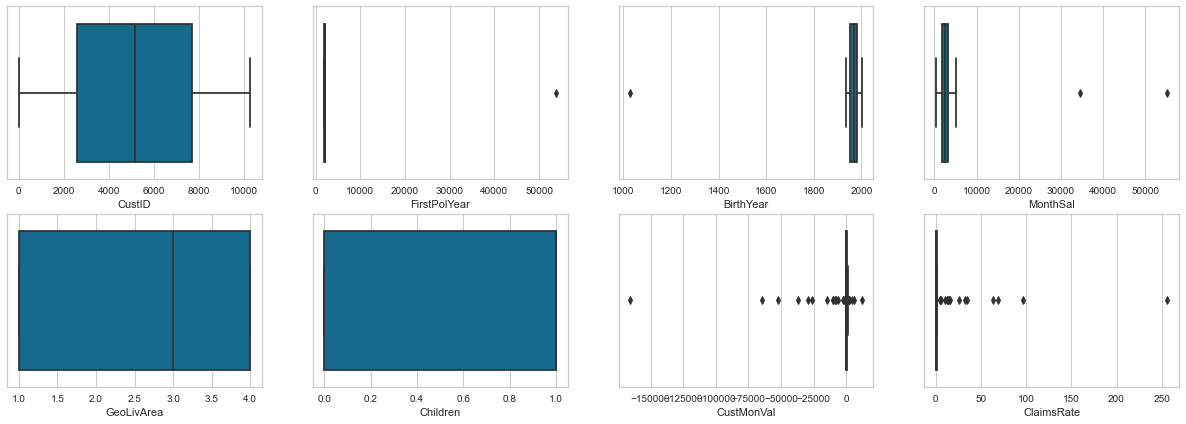

In [10]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(2, 4, figsize=(21, 7))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(x=ds[var], ax=subplot)

The above plotted boxplots are useful to conclude that some of the considered variables present some values that are clearly distant from the others. “FirstPolYear” presents a single observation that differs from the others and was, therefore, considered and treated as an outlier. Similarly, the “BirthYear” variable boxplot shows a single point far from the majority of the other values of this variable. This was also considered an outlier of the dataset.

Adding to these two described situations, the boxplots from the variables “MonthSal”, “CustMonVal” and “ClaimsRate” also present some dispersion. In other words, there are some observations that are quite different when considering the universe of observations of that variable. Although, considering what is the meaning of these variables and what these represent, they were not considered as outliers.

C:\Users\lotar\AppData\Local\Temp\ipykernel_28116\3001160745.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


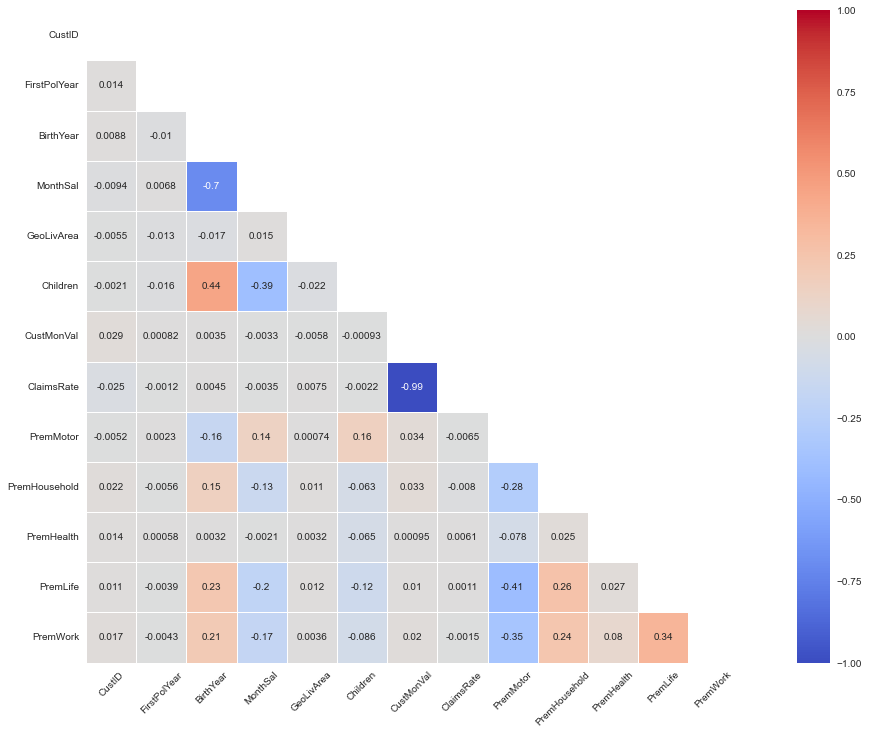

In [11]:
#Pearson Correlation only for numerical
corr = ds[numerical].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(21, 12))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 10})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Pearson Correlation measures the strength of the linear relationship between two variables. A correlation heatmap was plotted to graphically represent the correlation between all the different variables. 

In the graph above, it can be highlighted that the Claim Rate and the Customer Monetary Value have an almost perfect negative correlation, as the claim rate increases the monetary value of the costumer decreases. When the claim rate increases, the insurance company will suffer more costs therefore the costumers monetary value will decrease since its annual profit also decreases. On the other hand, the Monthly Salary and the Birth year also have a strong correlation, when the salary increases the birth year decreases, meaning that as a costumers’ age increases its monthly income increases too. 

## Data Preparation 

In [12]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [13]:
# Drop ID

X.drop("CustID", axis=1, inplace=True)

#Birth Year (1028)

X.drop(X.index[X['BirthYear'] == 1028.00], inplace = True)

#First Pol Year (53784)

X.drop(X.index[X['FirstPolYear'] == 53784.00], inplace = True)

#Missing Values

#FirstPolYear
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X['FirstPolYear'] = imp.fit_transform(X['FirstPolYear'].values.reshape(-1,1))[:,0]

#BirthYear
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X['BirthYear'] = imp.fit_transform(X['BirthYear'].values.reshape(-1,1))[:,0]

#Educational Degree
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X['EducDeg'] = imp.fit_transform(X['EducDeg'].values.reshape(-1,1))[:,0]

#Monthly Salary 
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['MonthSal'] = imp.fit_transform(X['MonthSal'].values.reshape(-1,1))[:,0]

#GeoLivArea
X = X.dropna(subset=['GeoLivArea'], how='all')


#Children
X['Children'] = X['Children'].fillna(0)

#PremMotor
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['PremMotor'] = imp.fit_transform(X['PremMotor'].values.reshape(-1,1))[:,0]

#PremHealth
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['PremHealth'] = imp.fit_transform(X['PremHealth'].values.reshape(-1,1))[:,0]

#PremWork
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['PremWork'] = imp.fit_transform(X['PremWork'].values.reshape(-1,1))[:,0]

#PremLife
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['PremLife'] = imp.fit_transform(X['PremLife'].values.reshape(-1,1))[:,0]

#Bin monthly salary

binsInterval = [0, 1000, 2000, 3000, 4000, 5000, 60000] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0, 1000]', '(1000, 2000]',  '(2000, 3000]', '(3000, 4000]', '(4000, 5000]', '(>5000]']
X['MonthSal_binned'] = pd.cut(X['MonthSal'], bins = binsInterval, labels=intervalLabels)

# Drop Monthly Salary

X.drop("MonthSal", axis=1, inplace=True)

#Transforming the Educational Degree into numerical categories
for i in range(len(X['EducDeg'].values)):
    if X['EducDeg'].values[i] == b'2 - High School':
        X['EducDeg'].values[i] = '2'
    elif X['EducDeg'].values[i] == b'1 - Basic':
        X['EducDeg'].values[i] = '1'
    elif X['EducDeg'].values[i] == b'3 - BSc/MSc':
        X['EducDeg'].values[i] = '3'
    else:
        X['EducDeg'].values[i] = '4'   
        
X = X.astype({'EducDeg':'float'})

#Econding MonthlySal_Binned

cols = ['MonthSal_binned']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

The first step in preparing the data was to remove the Costumer ID variable since it was not considered relevant for the development of customers’ profiles.  For the BirthYear and FirstPolYear variables, two values were removed from the sample since they were considered typo errors. 

The missing values were treated for almost all of the variables. In the variables FirstPolYear and Birth Year the median was choosen to fill the missing values. For the variables Monthly Salary, PremMotor, PremHealth, PremLife and PremWork the mean was used to replace the missing values, since the average values would not add value to the data set but keep it balanced. 

The missing values in the Children variable represent a no response, so it was considered that those costumers did not have children. In the living area there was only one missing value, so it was decided to drop that value has it would not affect the data set. The missing values for the Education degree were replaced for the most frequent category, in this case Bsc and Msc, and additionally the categories for this variable were transformed into numerical ones for easier analysis. 

Lastly, the Monthly Salary was divided in intervals of 1000 euros until 5000 euros, in order to  better represent this variable and provide further analysis for costumer profiling. 

In [14]:
#Checking Missing Values 
print(X.isnull().sum())

#Checking Variables' type
X.info()

FirstPolYear                    0
BirthYear                       0
EducDeg                         0
GeoLivArea                      0
Children                        0
CustMonVal                      0
ClaimsRate                      0
PremMotor                       0
PremHousehold                   0
PremHealth                      0
PremLife                        0
PremWork                        0
MonthSal_binned_(0, 1000]       0
MonthSal_binned_(1000, 2000]    0
MonthSal_binned_(2000, 3000]    0
MonthSal_binned_(3000, 4000]    0
MonthSal_binned_(4000, 5000]    0
MonthSal_binned_(>5000]         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10293 entries, 0 to 10295
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FirstPolYear                  10293 non-null  float64
 1   BirthYear                     10293 non-null  float64
 2   EducDeg                  

In [15]:
# Get a copy of the dataframe before normalization for results' analysis
X_beforeNorm = X.copy(deep=True)

In [16]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values), columns=X.columns,index=X.index)

### Analyze Principal Components

The PCA technique consists of reducing the dimensionality of the data to increase interpretability while minimizing information loss. It does so by creating new and uncorrelated variables that can maximize variance. It was applied the PCA method to visualize all the components and the power of each other and how much of them can explain the data.

In [17]:
# Let's use PCA to visualize with only two components
pca2 = PCA(n_components = 2)
pca2.fit(X)
X_pca2 = pca2.transform(X)
print(X_pca2.shape)

(10293, 2)


In [18]:
# Fit the PCA algorithm to data 
pca = PCA().fit(X)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(X.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.296222,0.296222
1,2,0.229702,0.525924
2,3,0.131837,0.657762
3,4,0.108166,0.765928
4,5,0.073458,0.839385
5,6,0.056082,0.895467
6,7,0.049838,0.945305
7,8,0.040020,0.985325
8,9,0.007495,0.992820
9,10,0.005979,0.998799


 It could be inferred that the number of components that has a variance explained make the highest point between 7 and 9 dimensions when compared to 17 of all datasets.

Text(0, 0.5, 'Variance explained')

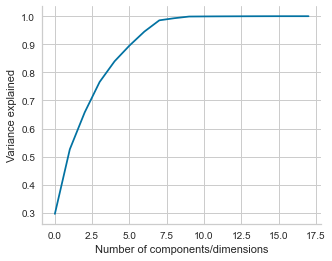

In [19]:
# Plot the cumulative explained variance

# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Decoration
sns.despine()
plt.xlabel('Number of components/dimensions')
plt.ylabel('Variance explained')


## Modeling - K-Means - 7 Components

The K-Means clustering is an unsupervised machine learning algorithm that groups data points through an iterative procedure. Is a partitional clustering methodology since a data point can only be assigned to a single cluster, meaning that different clusters can’t possess the same data point.

The algorithm starts by assigning a random number (K) of centroids – the centre of a cluster. Then, it calculates the distance (e.g. euclidean distance) of each data point to the centroids and assigns each datapoint to the nearest centroid. Afterwards, it calculates the average of each centroid’s data points and it substitutes the centroids’ location to the average and so on. The algorithm repeats this step until obtains some kind of convergence between the data.

In [20]:
# Apply the dimension reduction to the dataset (for 7 components)
pca_reduced = PCA(n_components = 7)
pca_reduced.fit(X)
X_pca_reduced = pca_reduced.transform(X) 
print(X_pca_reduced.shape)

(10293, 7)


In order to define the number of clusters (K) to implement in the model, it was implemented the elbow and silhouette method, as we’ve seen in class. The defined range of K in K-means was 1 to 20, as suggested by the professor.

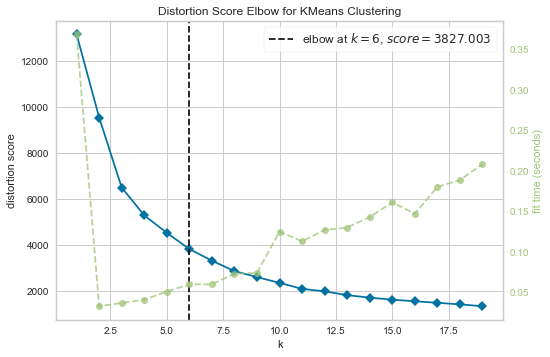

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Apply the Elbow method to select K
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=123)
visualizer.fit(X_pca_reduced)
visualizer.show() 

From the graphical visualization of the elbow method, it is possible to observe that the optimal number of K is 7, meaning that the interception is the point where the distortion (Within-Cluster-Sum of Squared Errors) starts to gradually decrease.

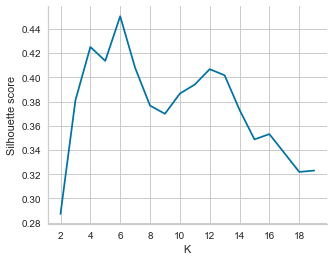

In [22]:
# Select K based on the Silhouette method
# ATTENTION! Depending on the computer this can take long time to run (more than 10 minutes)
sil = []

# Dissimilarity can only be measured in more than 1 partition, therefore it starts on K=2
for k in range(2, 20):
  km = KMeans(n_clusters = k, random_state=123).fit(X)
  labels = km.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))


# Show Results
# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(range(2, 20), sil, 'bx-')
# Decoration
sns.despine()
fmt = "{x:,.2f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xlabel('K')
plt.ylabel('Silhouette score')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

In [23]:
# Apply the K-Means for K=7 and K = 6
K=7
K1=6
kmeans = KMeans(n_clusters=K, random_state=123)
kmeans1 = KMeans(n_clusters=K1, random_state=123)

allDistances = kmeans.fit_transform(X_pca_reduced)
allDistances1 = kmeans1.fit_transform(X_pca_reduced)

y_kmeans = kmeans.predict(X_pca_reduced)
y_kmeans1 = kmeans1.predict(X_pca_reduced)

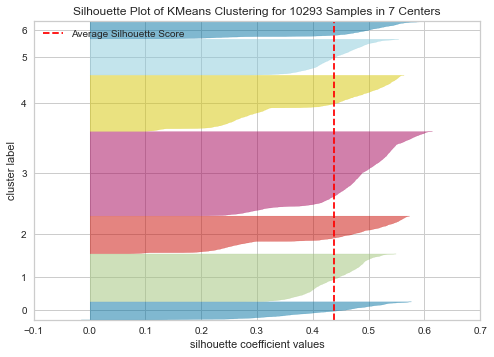

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10293 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [24]:
# Visualize Silhouette for K=7
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_pca_reduced)
visualizer.show()

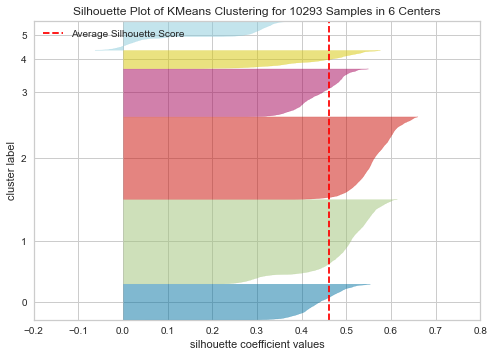

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10293 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
# Visualize Silhouette for K=6
visualizer1 = SilhouetteVisualizer(kmeans1, colors='yellowbrick')
visualizer1.fit(X_pca_reduced)
visualizer1.show()

The Silhouette method scores the similarity between the datapoints and its clusters when compared to other clusters. By applying this method, the number of clusters that outputs a better score is a K = 6. Although that is verified graphically when compared to K = 7, it is possible to observe that a K = 6 produces a somewhat disproportionate clusters.

Text(0, 0.5, 'Frequency in cluster')

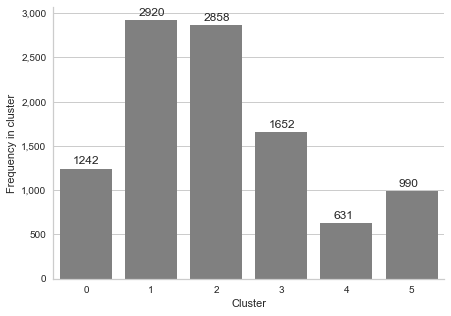

In [26]:
# Plot clusters cardinality (K = 6)

# Count observations per cluster
freqByCluster1 = X_beforeNorm.groupby(y_kmeans1).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans1, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster1):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}")
sns.despine()

plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")

When plotting the cluster frequency with K = 6 it is possible to observe that clusters 4 and 5 have the lowest frequency. 

Text(0, 0.5, 'Frequency in cluster')

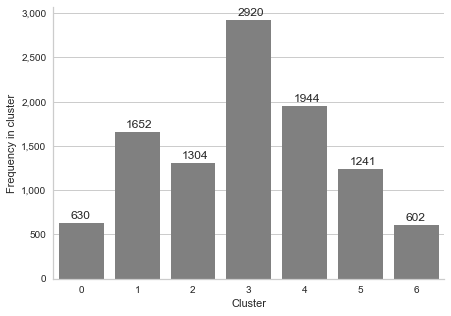

In [27]:
# Plot clusters cardinality (K = 7)

# Count observations per cluster
freqByCluster = X_beforeNorm.groupby(y_kmeans).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}")
sns.despine()

plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")

When plotting the frequency for a K = 7 there’s also low presence of clusters 0 and 6 in comparison to the others.

Text(0, 0.5, 'Sum of distances to centroid')

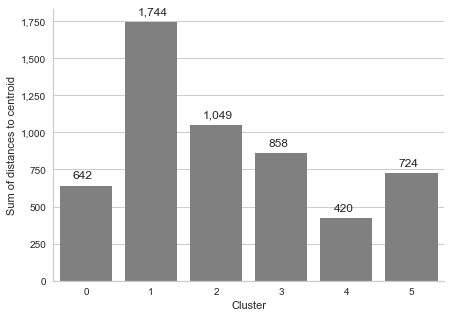

In [28]:
# Plot clusters magnitude ( K=6)

# Compute Magnitude
X['distanceToCentroid'] = np.min(allDistances,axis=1)
magnitude1 = X['distanceToCentroid'].groupby(y_kmeans1).sum()
X = X.drop(columns=['distanceToCentroid'])

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g1 = sns.barplot(x=magnitude1.index, y=magnitude1.values, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(magnitude1):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}")
sns.despine()
plt.xlabel("Cluster")
plt.ylabel("Sum of distances to centroid")

Text(0, 0.5, 'Sum of distances to centroid')

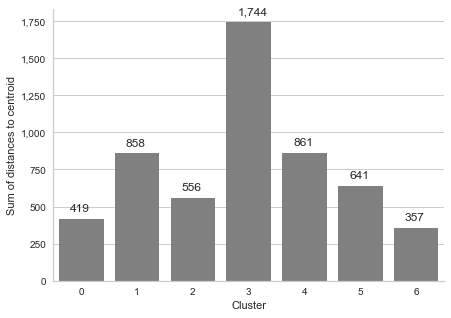

In [29]:
# Plot clusters magnitude ( K=7)

# Compute Magnitude
X['distanceToCentroid'] = np.min(allDistances,axis=1)
magnitude = X['distanceToCentroid'].groupby(y_kmeans).sum()
X = X.drop(columns=['distanceToCentroid'])

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.barplot(x=magnitude.index, y=magnitude.values, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(magnitude):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}")
sns.despine()
plt.xlabel("Cluster")
plt.ylabel("Sum of distances to centroid")

In terms of magnitude, cluster 4 is the lowest for K = 6 and for K = 7 are again clusters 0 and 6.

Text(0, 0.5, 'Magnitude')

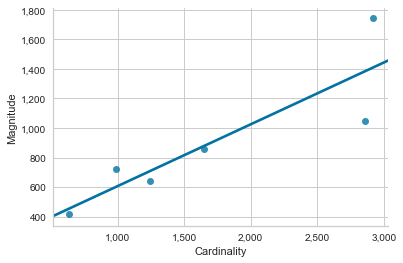

In [30]:
# Plot cardinality vs magnitude (K=6)

# Draw
fig, ax = plt.subplots(figsize=(6,4))
g1 = sns.regplot(x=freqByCluster1, y=magnitude1, scatter=True, seed=123,truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.xlabel("Cardinality")
plt.ylabel("Magnitude")

By comparing the relationship between frequency and magnitude, it is possible to observe that a K = 6 produces more deviant results. However, when visualizing the intercluster distances, a K = 6 produces overall closest results, although K = 7 outputs closer results between pairs.

Text(0, 0.5, 'Magnitude')

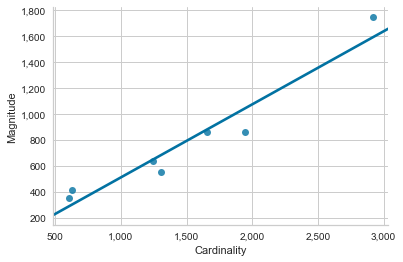

In [31]:
# Plot cardinality vs magnitude (K=7)

# Draw
fig, ax = plt.subplots(figsize=(6,4))
g = sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=123,truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.xlabel("Cardinality")
plt.ylabel("Magnitude")


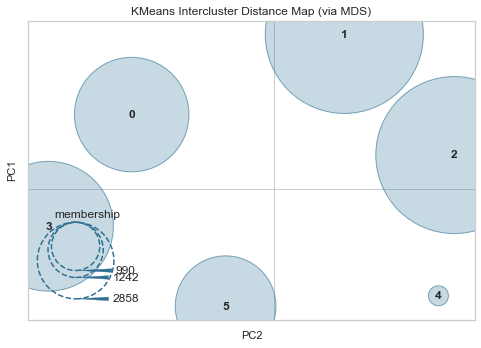

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [32]:
# Visualizing the clusters sizes and distances in 2D ( K=6)
visualizer = InterclusterDistance(kmeans1)
visualizer.fit(X_pca_reduced)
visualizer.show()

C:\Users\lotar\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


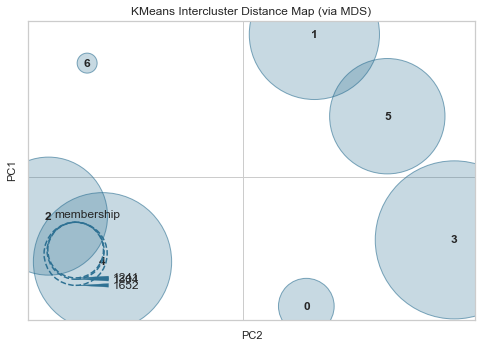

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [33]:
# Visualizing the clusters sizes and distances in 2D (K=7)
visualizer = InterclusterDistance(kmeans)
visualizer.fit(X_pca_reduced)
visualizer.show()

Given these results, 7 clusters were applied to the dataset since the data seemed, globally,  more balanced than using 6 clusters.  

In [34]:
# Create a dataframe with the weights per component
wheightsDF = pd.DataFrame(pca.components_,columns=X.columns)
wheightsDF

,FirstPolYear,BirthYear,EducDeg,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,"MonthSal_binned_(0, 1000]","MonthSal_binned_(1000, 2000]","MonthSal_binned_(2000, 3000]","MonthSal_binned_(3000, 4000]","MonthSal_binned_(4000, 5000]",MonthSal_binned_(>5000]
0,9.059742e-03,-3.239974e-01,2.783329e-02,2.778169e-02,-5.412505e-01,-4.669416e-05,4.662458e-05,-1.130090e-03,-2.748482e-04,6.738998e-04,-1.779971e-03,-7.150952e-04,-0.026387,-0.394292,-0.264261,0.606951,0.077803,0.000185
1,1.333555e-03,1.527086e-01,-5.746144e-02,8.037013e-03,-7.581605e-02,-1.832912e-04,3.607452e-04,-9.004008e-03,3.949971e-03,1.426260e-03,5.208596e-02,1.058160e-02,0.026276,0.625226,-0.750837,0.096323,0.002957,0.000055
2,5.686179e-03,-1.241717e-02,1.805826e-02,-9.993016e-01,-6.707430e-03,1.354819e-04,-1.908566e-04,3.957684e-05,-5.038331e-04,-3.706431e-05,-5.108241e-03,-5.389334e-04,-0.007663,-0.003893,-0.014916,0.022289,0.004342,-0.000159
3,3.398596e-03,1.583247e-02,-7.119034e-02,-1.037698e-02,-7.332300e-01,1.091703e-04,-2.576583e-05,-7.657501e-03,3.346980e-03,1.421222e-03,4.925377e-02,8.603479e-03,0.044808,0.101468,0.100254,-0.571648,0.324388,0.000730
4,-2.474348e-02,2.494840e-01,-5.432561e-01,-1.666191e-02,7.682056e-02,5.903829e-04,-1.543785e-04,-1.710488e-02,1.250035e-02,1.108493e-03,1.706182e-01,3.112306e-02,0.651626,-0.370070,-0.197193,-0.067456,-0.017485,0.000579
5,-9.977278e-01,9.937097e-03,4.878976e-02,-4.872798e-03,-2.628497e-02,1.212437e-04,-1.556296e-04,8.231664e-04,5.421885e-05,-1.281193e-04,-1.067093e-02,-2.783766e-03,0.010861,0.007645,0.005806,0.006666,-0.031120,0.000143
6,-1.073838e-02,-1.895152e-01,4.429444e-01,1.119468e-02,3.234194e-01,-6.173652e-04,3.330422e-04,9.107695e-03,-6.458209e-03,8.273679e-04,-9.684111e-02,-1.435438e-02,0.179105,-0.250699,-0.339968,-0.217422,0.628931,0.000053
7,-6.027389e-02,-3.207060e-01,-6.824522e-01,-4.929868e-03,2.183300e-01,1.306122e-04,-1.119613e-04,-3.252264e-03,2.795797e-03,-4.114792e-04,3.173055e-02,7.273514e-03,-0.451391,0.041566,-0.011764,0.004902,0.416364,0.000324
8,-6.829577e-03,4.885338e-01,1.526479e-01,-5.265526e-04,9.779903e-03,-4.137202e-04,8.576710e-04,-3.115745e-02,1.132683e-02,-9.846910e-04,7.361621e-01,2.548271e-02,-0.299740,-0.134588,0.035912,0.147733,0.251262,-0.000580
9,-1.174004e-03,-6.562706e-01,8.295827e-02,-8.220421e-04,6.758444e-02,8.566536e-04,-1.153113e-03,-1.758318e-02,-2.954994e-05,-9.174185e-04,6.411241e-01,-3.980693e-03,0.213607,0.153117,0.013122,-0.147283,-0.235674,0.003111


In [35]:
# Study the weights of component 7
comp = abs(wheightsDF.iloc[6])  ## index 6 is component 7
comp = comp.sort_values(ascending=False)
comp

MonthSal_binned_(4000, 5000]    0.628931
EducDeg                         0.442944
MonthSal_binned_(2000, 3000]    0.339968
Children                        0.323419
MonthSal_binned_(1000, 2000]    0.250699
MonthSal_binned_(3000, 4000]    0.217422
BirthYear                       0.189515
MonthSal_binned_(0, 1000]       0.179105
PremLife                        0.096841
PremWork                        0.014354
GeoLivArea                      0.011195
FirstPolYear                    0.010738
PremMotor                       0.009108
PremHousehold                   0.006458
PremHealth                      0.000827
CustMonVal                      0.000617
ClaimsRate                      0.000333
MonthSal_binned_(>5000]         0.000053
Name: 6, dtype: float64

In [36]:
# Check the mean values of each cluster for top 30 relevant features
top_features = comp[:30].index

#Apply K =7
clustersMeanDF = pd.DataFrame(X_beforeNorm[top_features].groupby(y_kmeans).mean(),columns=top_features)
clustersMeanDF.transpose()

,0,1,2,3,4,5,6
"MonthSal_binned_(4000, 5000]",0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.996678
EducDeg,1.758730,2.546005,2.582055,2.418836,2.575103,2.594682,2.578073
"MonthSal_binned_(2000, 3000]",0.000000,0.000000,1.000000,0.000000,0.999486,0.000000,0.000000
Children,0.769841,0.000000,0.888037,0.889041,0.875000,1.000000,0.134551
"MonthSal_binned_(1000, 2000]",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
"MonthSal_binned_(3000, 4000]",0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
BirthYear,1993.788889,1947.021186,1967.746166,1985.038014,1967.887860,1956.245770,1942.830565
"MonthSal_binned_(0, 1000]",0.998413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PremLife,99.623333,43.876301,25.780782,50.923417,26.889535,31.150148,37.261573
PremWork,97.684569,41.150529,25.023228,50.934271,25.347972,32.597783,40.413474


#### Some insights:

**Cluster 0**: Young adults with low purchasing power
* Most have a monthly income of 1000 euros maximum,
* The less educated persons (most with only basic education)
* Most have, at least, 1 child
* Young adults, most being around 22 years old
* Present a relatively low percentage of claims rate
* Lowest Motor premiums and highest house premiums
* Most profitable segment

**- Likely to prefer more basic insurance plans**

**Cluster 1**: Senior people with no children and high purchasing power
* All customers have a monthly income between 3000 and 4000 euros
* Educated people (Bachelor/ Masters degree)
* No children
* Senior people, on average 69 years
* Low percentage of claims rate
* Similar premiums in motor, housing and health

**- Likely to prefer more premium insurance plans**

**Cluster 2**: Middle-aged customers with medium purchasing power
* Educated people
* Monthly Salaries between 2000 and 3000 euros
* Most have, at least, 1 child
* Average birth Year of 1967, being characterized by people of around 55 years old
* The second highest PremMotor (378,79)
* Low PremLife, PremWork and PremHealth

**- Likely to prefer more standard insurance plans**

**Cluster 3**: Educated young adults with low purchasing power 
* Young adults, born in 1985, on average
* Educated people
* Monthly salary between 1000 and 2000 euros
* Second highest claims rate 
* Second less profitable 

**- Likely to prefer more basic insurance plans**

**Cluster 4**: Profitable Customers, in their middle age with lowest claim rate.
* Middle-class salary between 2000 and 3000 euros
* Educated people
* Most of the customers have children
* Middle-aged people with, on average, 48 years
* Living area – region 4
* Highest Motor premiums although presenting the lowest claims rate
* Lowest Health premiums

**- Likely to prefer more standard plans**

**Cluster 5**: Senior customers with children and high purchasing power
* All customers have a monthly salary between 3000 and 4000 euros
* The average birth year is 1956, representing customers around the age of 60 years.
* Educated people
* All the customers have at least one child.
* Presents high motor premiums and the third-highest claims rate
* Presents similar premiums in Health and Housing 

**- Likely to prefer more premium/full coverage plans**

**Cluster 6**: Oldest customers with no children and high purchasing power
* Highest purchasing power with a monthly income above 4000 euros
* Educated people
* Most have no children
* Highest health premium
* Less profitable
* Highest claims rate

**- Likely to prefer more premium/full coverage plans**

## Hierarchical clustering

This clustering technique is a very useful segmentation tool. In a simple way, this method consists of, firstly, considering certain points (the points that one wants to cluster into groups), assigning separate clusters to each one of these points. Afterwards, taking into account possible similarities between these points, combining the ones that are most similar together. This process is repeated until only one single cluster is left, building a hierarchy of clusters. This type of clustering can be either agglomerative or divisive.

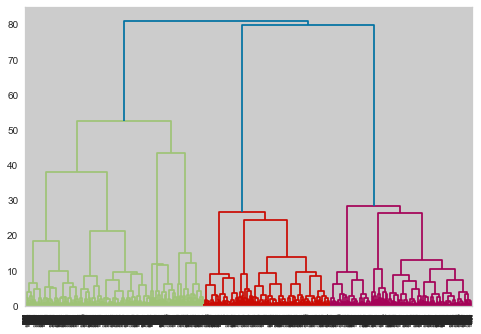

In [37]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

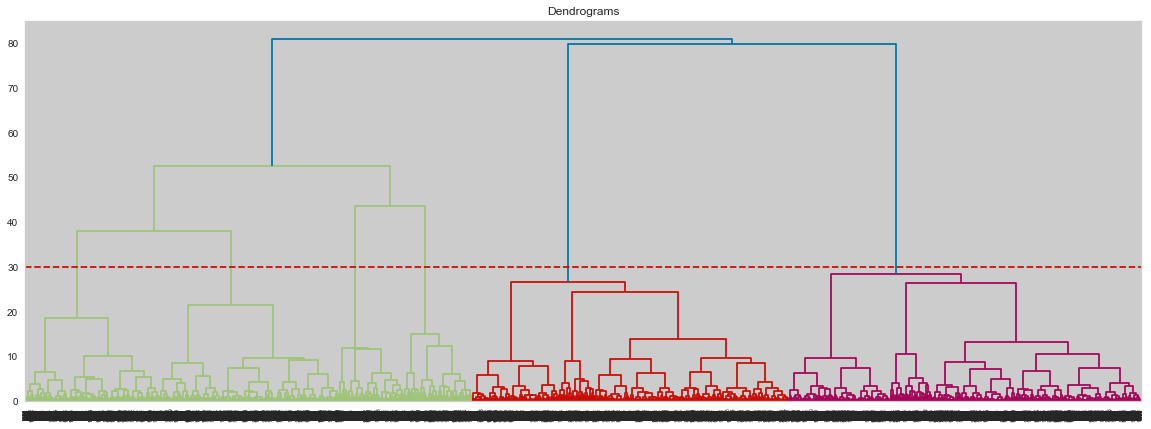

In [38]:
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  
dend = sch.dendrogram(sch.linkage(X, method='ward'))
plt.axhline(y=30, color='r', linestyle='--')

In [39]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X)

array([0, 3, 0, ..., 0, 2, 0], dtype=int64)